s# Generative Adversarial Network with TensorFlow

In [152]:
import shutil

# for model
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, datasets, Sequential, losses, optimizers
import math

# for GIFs
import glob
import imageio
import os
import shutil
import sys
import PIL
import time

from IPython import display

## Hyperparameters

In [153]:
BATCH_SIZE = 128
NOISE_DIM = 100
IMGS_TO_GEN = 16
EPOCHS = 20

Buffer size is primarily used for random sampling using `tf.data.Dataset.shuffle`. Unused for now, Since i will set a seed to make debugging and optimizing easier.

Another seed is stored for... idk what.

In [154]:
BUFFER_SIZE = 60000
tf.random.set_seed(420)
seed = tf.random.normal([IMGS_TO_GEN, NOISE_DIM])

Note that it is quite natural to add channels other than just red, green, and blue. Many satellite images, in particular for agriculture and meteorology, have tens to hundreds of channels, generating hyperspectral images instead. They report data on many different wavelengths.

For now, I will stick to 256 channels (2 to the power of 8) to keep it simple.

In [155]:
FEATURE_MAP_SIZE = 7
CHANNELS = 256
SPATIAL_TENSOR = (FEATURE_MAP_SIZE, FEATURE_MAP_SIZE, CHANNELS)
FILTERS = (CHANNELS, 64, 1)

## Data

Load the data from keras.

In [156]:
(train_imgs, train_lbls), (_, _) = datasets.mnist.load_data()

Reshape img tensor into *(n_instances, px width, px height, channels)*. Channels are the number of color channels in the image. this could be 1 for grayscale or 3 for RGB

Since our images are grayscale, set channels to 1 and transform them to float32, since we normalize the data to fall between 0 and 1.

In [157]:
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype("float32")
train_imgs = (train_imgs - 127.5) / 127.5

Create a tf dataset and make batches.  Smaller batches hinder training potential, but are less memory intensive.

From TensorFlow docs:
* for perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required
* reshuffle_each_iteration controls whether the shuffle order should be different for each epoch (try without)
* To shuffle an entire dataset, set buffer_size=dataset.cardinality(). This is equivalent to setting the buffer_size equal to the number of elements in the dataset, resulting in uniform shuffle.

In [158]:
train_df = tf.data.Dataset.from_tensor_slices(train_imgs)
train_df = train_df.batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

## Models

### Generator

Start with a `Dense` layer that takes an input of 100 random values (noise) and transforms it into a vector of size 7×7×256=12544.

`BatchNormalization` helps stabilize training by normalizing the activations of the layer before it.

For hidden layers, `LeakyReLU` is better than `ReLU`, since it avoids "dying ReLU" problem (sparse gradients). Output layer should have `tanh` activation function, since it our values are normalized to be between -1 and 1, while `sigmoid` outputs values between 0 and 1.

`Reshape` transforms 49-element vector into a 7x7x1 tensor, that can be interpreted as a 7px×7px image with 1 channel (one feature map). It converts the vector representation into a spatial representation that can then be processed by convolutional layers.

Core of our GAN network: `Conv2DTranspose` does upsampling (it increases the spatial dimensions).  It inserts values into the input and performs a convolution. It adds padding and then applies a standard convolution operation to this expanded output. The kernel weigths are learned during training.

While sparse gradients can occur due to ReLU, they also occur as a result of max pooling when doing convolutions. This is why we will use strides. 

In [159]:
def build_generator():
    model = Sequential()
    model.add(layers.Input(shape=(100,)))

    model.add(layers.Dense(math.prod(SPATIAL_TENSOR), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape(SPATIAL_TENSOR))

    model.add(layers.Conv2DTranspose(FILTERS[0], (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(FILTERS[1], (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(FILTERS[2], (5, 5), strides=(2, 2), padding="same", activation="tanh", use_bias=False))

    return model

In [160]:
generator = build_generator()
generator.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 7, 7, 256)      │     1,638,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 14, 14, 64)     │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,355,456 (12.80 MB)

 Trainable params: 3,329,728 (12.70 MB)

 Non-trainable params: 25,728 (100.50 KB)

### Discriminator

The discriminator is a convolutional neural network that takes an image as input and outputs a single value, representing the probability that the input is real. In other words, it is a classifier.

Input shape is the same as the output shape of the generator. It is 28px×28px image with 1 channel. 

We gradually go from 28×28 elements to 1 by droping out a third of the neurons every convolution.

Lastly, we flatten the remaining neurons into a 1D array that we can pass to the `Dense` output layer with a single output.

In [161]:
def build_discriminator():
    model = Sequential()
    model.add(layers.Input(shape=(28, 28, FILTERS[2])))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [162]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Loss

It will use cross entropy loss function.
`discriminator_loss` will quantify how well the discriminator is able to distinguish real images from fake. It compares its predictions on real images to an array of 1's and fake to an array of 0's.
`generator_loss` will quantify how well the generator is able to trick the discriminator. It compares the discriminator's predictions on the generated images to an array of 1's (if its predictions are close to 1, the generator is doing well).

In [163]:
cross_entropy = losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss 

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

Since we are training two networks, we need two optimizers.

In [164]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

We will save checkpoints of the model at regular intervals. This is useful for resuming training at a later time.

In [165]:
def make_dir(dir_names: list[str]) -> None:
    for dir_name in dir_names:
        try:
            os.mkdir(dir_name)
        except FileExistsError:
            c = input(f"Directory '{dir_name}' already exists. Overwrite contents? [y/N]: ").lower()
            match c:
                case "y":
                    try:
                        os.rmdir(dir_name)
                    except OSError:
                        shutil.rmtree(dir_name)

                    os.mkdir(dir_name)
                case "n":
                    continue

In [166]:
checkpoint_dir = "./training_checkpoints"
image_dir = "./generated_images"

make_dir([checkpoint_dir, image_dir])

In [167]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

## Training
The training loop begins with generator receiving a random seed as input. That seed is
used to produce an image.

The discriminator is then used to classify real images (drawn from the training set)
and fakes images (produced by the generator).

The loss is calculated for each of these models, and the gradients are used to update
the generator and discriminator.

In [168]:
@tf.function
def train_step(images):
    """
    * generate random noise from a normal distribution using BATCH_SIZE and NOISE_DIM
        * generate an image using noise as input
        * make 2 predictions with discriminator, one with ground truth images, another
        * with the generated image
        * compute losses of both models
    * compute gradients of both models using their respective loss functions
    * apply gradients to both models using their respective optimizers
    """
    noise = tf.random.normal([1, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
       gen_loss, 
       generator.trainable_variables
    )
    gradients_of_discriminator = disc_tape.gradient(
       disc_loss,
       discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(zip(
       gradients_of_generator, 
       generator.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
       gradients_of_discriminator, 
       discriminator.trainable_variables
    ))

In [169]:
def generate_and_save_images(model, epoch, test_input):
    """
    * Notice `training` is set to False. This is so all layers run in inference mode (batchnorm).
      Inference mode means the model is not learning, it is only making predictions
    * make predictions using the generator model
    * plot the images in a 4x4 grid
    * save the plot to a file
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # here we are scaling the pixel values to be between 0 and 255 with the formula: (x + 1) * 127.5
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(image_dir, epoch))
    plt.imshow(gen_img[0, :, :, 0], cmap='gray')
    plt.show()

In [170]:
def train(dataset, epochs):
    """
    * for each epoch and for each batch in the dataset we call `train_step` with the
      batch and record the time it took to complete the epoch
    * clear the output
    * generate and save images using the generator model and the seed (noise) we d
      defined at the beginning
    * save the model every 15 epochs
    * print the time it took to complete the epoch
    """
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print("Time for epoch {} is {} sec".format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

This is how a random generated image looks like.

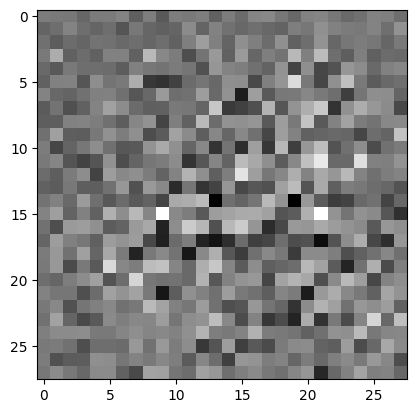

In [171]:
some_noise = tf.random.normal([1, 100])
gen_img = generator(some_noise, training=False)
plt.imshow(gen_img[0, :, :, 0], cmap='gray')
plt.show()

In [172]:
prediction = discriminator(gen_img, training=False)
prediction.numpy().item()

0.00373243005014956

We can now use `train` function to train our models and see output images.

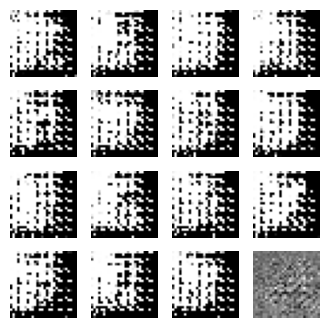

Time for epoch 1 is 47.01493000984192 sec


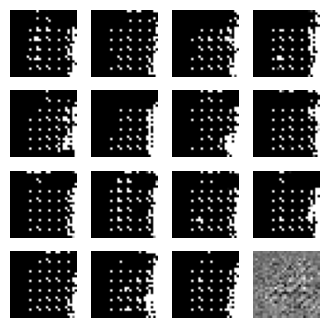

Time for epoch 2 is 50.018563747406006 sec


KeyboardInterrupt: 

In [173]:
train(train_df, EPOCHS)